In [1]:
import sys
import os
from IPython.core.display import display, HTML

"""
On Windows, sometimes, some cuda libraries does not work very well. One needs to add the cuda path mannually.
The following line is an example.
"""
#os.environ['NUMBAPRO_CUDALIB']=r"C:\Users\hyli\Anaconda3\envs\python36\Library\bin"
os.environ['NUMBAPRO_CUDALIB']=r"C:\Users\hyli93\Miniconda3\envs\python36\Library\bin"

"""
Because I have not realised this package. To use this package, one can not simply install with pip.
Instead, one needs to clone from the repo and append the path to this repo to the system path variable.
"""
sys.path.append('C:/Users/hyli93/Documents/GitHub/Phasing/')

"""
This line is totally optional. It only changes the cell width.
"""
display(HTML("<style>.container { width:95% !important; }</style>"))

# Import some other necessary packages
import numpy as np
import matplotlib.pyplot as plt
from scipy import ndimage
import PhaseTool   # This is the name of this package
import copy
from scipy import ndimage

# Create a smooth object

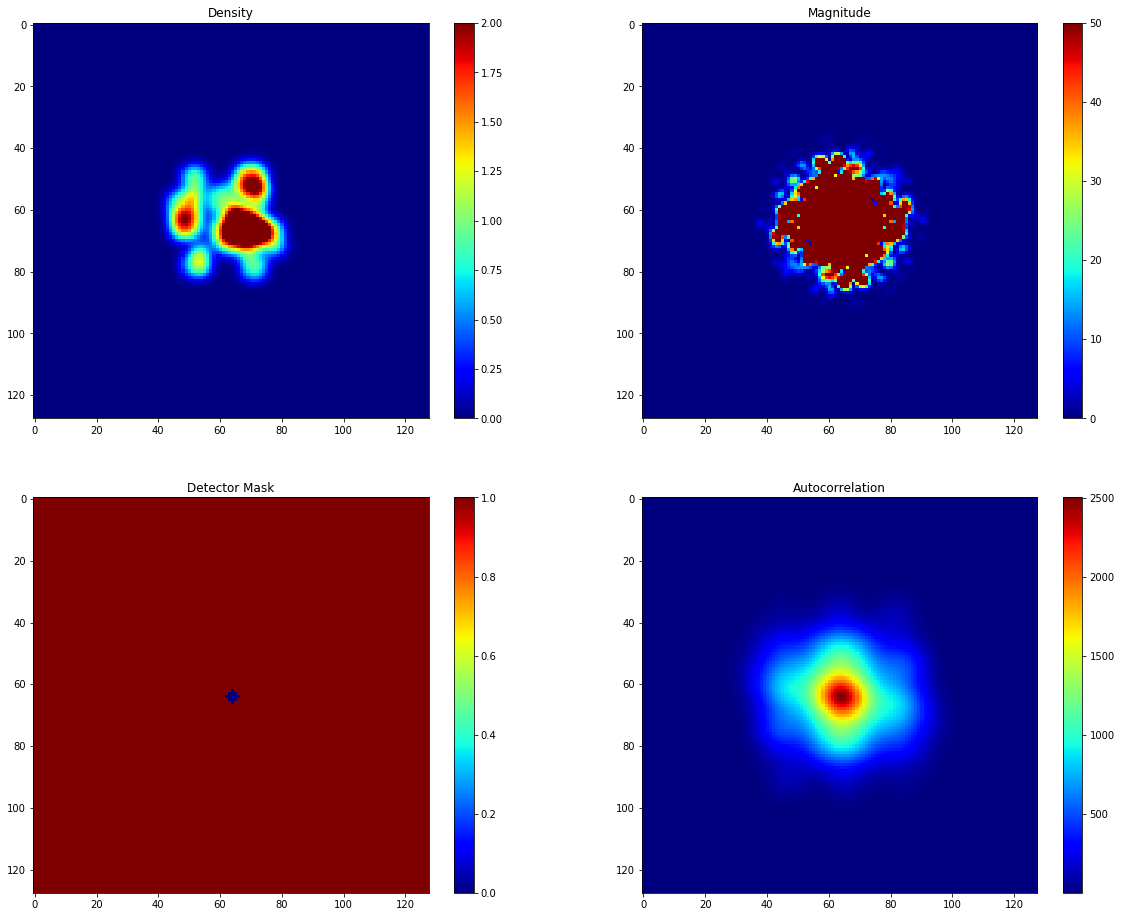

In [2]:
sample = PhaseTool.util.SmoothSample(support_length=32, space_length=128, obj_num=34)


############################################################################################################
#  Show sample information
############################################################################################################
# Set up the canvas
fig, axes = plt.subplots(nrows=2, ncols=2)
fig.set_figheight(16)
fig.set_figwidth(20)

im = axes[0,0].imshow(sample.density, vmin=0, vmax=2, cmap='jet')
fig.colorbar(im, ax=axes[0,0])
axes[0,0].set_title("Density")

im = axes[0,1].imshow(sample.intensity, vmax=50, cmap='jet')
fig.colorbar(im, ax=axes[0,1])
axes[0,1].set_title("Magnitude")

im = axes[1,0].imshow(sample.detector_mask,vmin=0, vmax=1, cmap='jet')
fig.colorbar(im, ax=axes[1,0])
axes[1,0].set_title("Detector Mask")

im = axes[1,1].imshow(PhaseTool.util.get_autocorrelation(sample.intensity), vmin=0.4 ,cmap='jet')
fig.colorbar(im, ax=axes[1,1])
axes[1,1].set_title("Autocorrelation")

# Show the canvas
plt.show()  

# Test Step 1: Try some RAAR

In [3]:
# Step 1: Create a object
alter_proj = PhaseTool.AlterProj.CpuAlterProj()

# Step 2: Initialize the object with the data
alter_proj.initialize_easy(magnitude=sample.magnitude,
                           magnitude_mask=np.ones_like(sample.magnitude,dtype=np.bool),
                           full_initialization=False)

# Step 3: Set initial guess
alter_proj.use_auto_support(threshold=0.04,gaussian_filter=True,sigma=1.0,fill_detector_gap=True,)

alter_proj.derive_initial_density(fill_detector_gap=True, method="Random")
    

alter_proj.set_algorithm(alg_name="RAAR")
alter_proj.set_beta_and_iter_num(beta=0.90,
                                 iter_num=1200,
                                 decay=True, 
                                 decay_rate=30)



The center of the diffraction is :
[64. 64.]
There is no gap on the detector. Use the original magnitude.
The true threshold is 98.88965686849211
There is no gap on the detector. Use the original magnitude.
The user uses a constant value for the beta value. This valuesbeta = 0.9
This values is recognized as the initial beta value for a list of decaying beta values. The length of this list is the iter_num valuewhich is 1200


In [4]:
# Step 4: Execute the algorithm of RAAR with 200 Iterations:
alter_proj.execute_algorithm()

# Save to history
alter_proj_hist=[copy.deepcopy(alter_proj),]

Using algorithm RAAR
Finishes self-consistency check.


# Visualization Section

The relative difference is 0.15995785728808823%


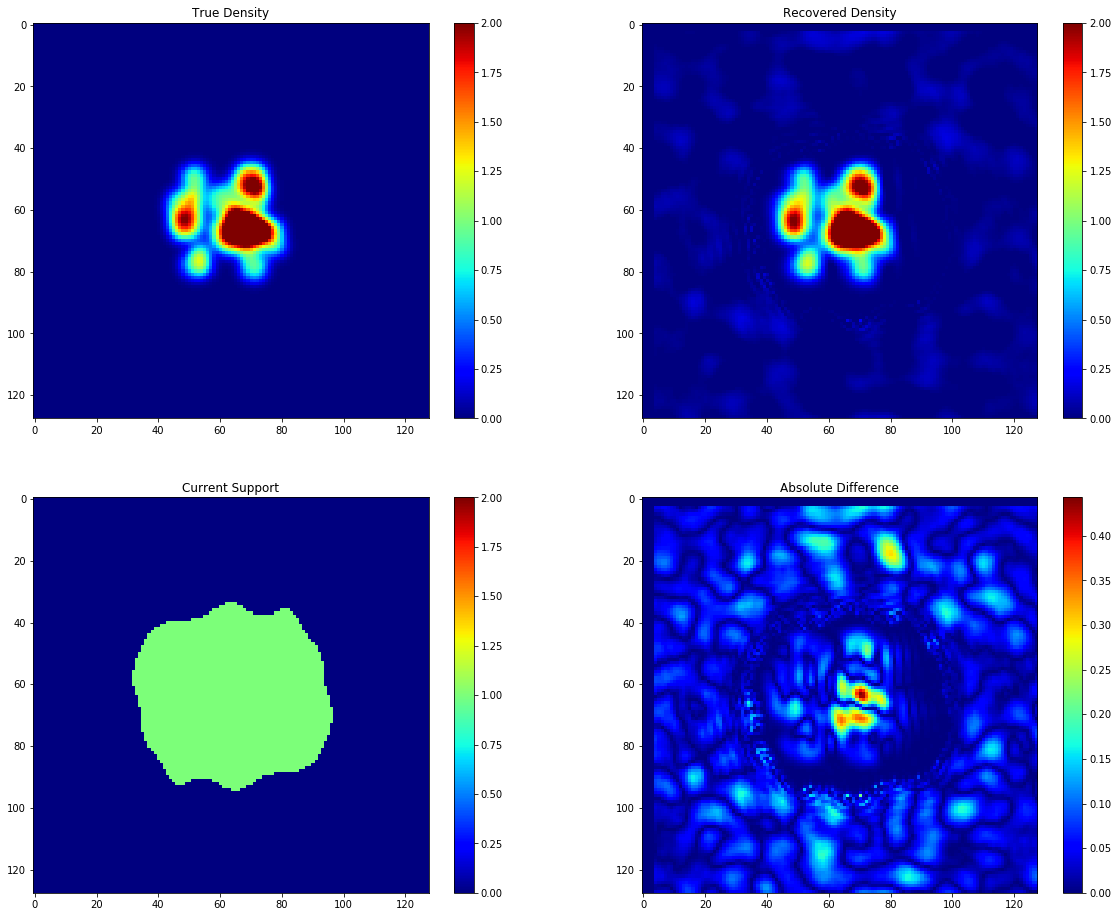

In [5]:
# Set up the canvas anc compare result
recover, _, _ = PhaseTool.util.resolve_trivial_ambiguity(array=np.fft.ifftshift(alter_proj.data_dict['density']), reference_array=sample.density)

print("The relative difference is {}%".format(np.sqrt(np.sum(np.square(recover - sample.density))) / np.sqrt(np.sum(np.square(sample.density)))))

fig, axes = plt.subplots(nrows=2, ncols=2)
fig.set_figheight(16)
fig.set_figwidth(20)

im = axes[0,0].imshow(sample.density, vmax=2, cmap='jet')
fig.colorbar(im, ax=axes[0,0])
axes[0,0].set_title("True Density")

im = axes[0,1].imshow(recover, vmin=0, vmax=2, cmap='jet')
fig.colorbar(im, ax=axes[0,1])
axes[0,1].set_title("Recovered Density")

im = axes[1,0].imshow(np.abs(np.fft.ifftshift(alter_proj.data_dict['support'])), vmax=2, cmap='jet')
fig.colorbar(im, ax=axes[1,0])
axes[1,0].set_title("Current Support")

im = axes[1,1].imshow(np.abs(sample.density - recover),cmap='jet')
fig.colorbar(im, ax=axes[1,1])
axes[1,1].set_title("Absolute Difference")

# Show the canvas
plt.show()  

# Test step 2: Try some ER with Shrink Wrap

In [6]:
# Copy from history
alter_proj = copy.deepcopy(alter_proj_hist[-1])

alter_proj.set_algorithm(alg_name="ER")
alter_proj.shrink_warp_properties(on=True,
                                    threshold_ratio=0.04,
                                    sigma=10.,
                                    decay_rate=100,
                                    threshold_ratio_decay_ratio=1.0,
                                    sigma_decay_ratio=0.8,
                                    filling_holes=True,
                                    convex_hull=False)

alter_proj.set_beta_and_iter_num(iter_num=500)

Enable shrink wrap functions.
The initial threshold ratio of the shrink warp algorithm is set to 0.04
The initial sigma of the shrink warp algorithm is set to 10.0
The decay_rate argument is set to be 100
Therefore, the shrink wrap algorithm will be applied every 100iterations of the projections. The change of the parameters of the shrink wrap function will occur after each application. Therefore, if you would like to use a constant parameter for all shrink wraps, please set the argument threshold_ratio_decay_ratio=1.0, and sigma_decay_ratio=1.0. By default, they are 0.9.
The threshold ratio will decay to 1.0 * (current ratio)after each application of the shrink wrap algorithm. To stop this decaying,please set threshold_ratio_decay_ratio=1. when calling this funciton. 
The sigma will decay to 0.8 * (current ratio)after each application of the shrink wrap algorithm. To stop this decaying,please set threshold_ratio_decay_ratio=1. when calling this funciton. 
As per request, when update t

In [7]:
alter_proj.execute_algorithm()

# Save to history
alter_proj_hist.append(copy.deepcopy(alter_proj))

Using algorithm ER
Finishes self-consistency check.


# Visualization Section

The relative difference is 0.08189750986865427%


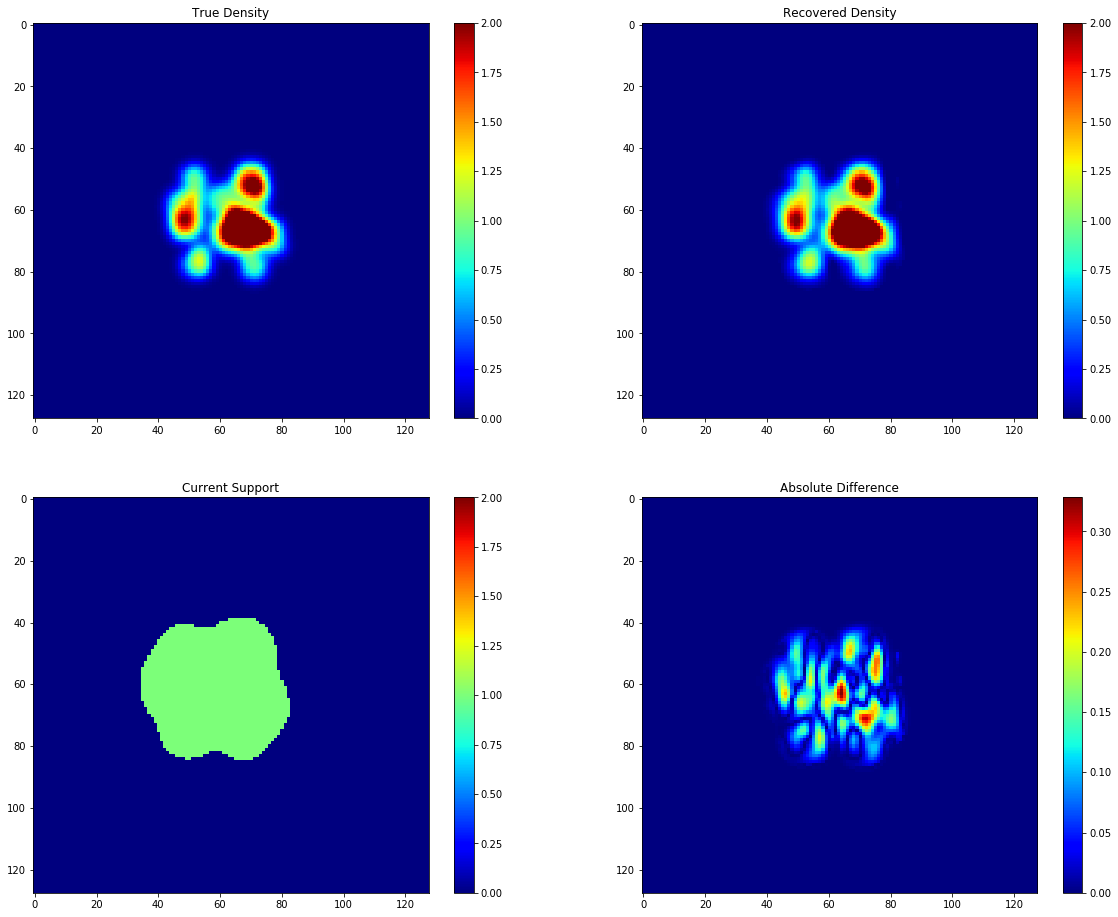

In [8]:
# Set up the canvas anc compare result
recover, _, _ = PhaseTool.util.resolve_trivial_ambiguity(array=np.fft.ifftshift(alter_proj.data_dict['density']), reference_array=sample.density)

print("The relative difference is {}%".format(np.sqrt(np.sum(np.square(recover - sample.density))) / np.sqrt(np.sum(np.square(sample.density)))))

fig, axes = plt.subplots(nrows=2, ncols=2)
fig.set_figheight(16)
fig.set_figwidth(20)

im = axes[0,0].imshow(sample.density, vmax=2, cmap='jet')
fig.colorbar(im, ax=axes[0,0])
axes[0,0].set_title("True Density")

im = axes[0,1].imshow(recover, vmin=0, vmax=2, cmap='jet')
fig.colorbar(im, ax=axes[0,1])
axes[0,1].set_title("Recovered Density")

im = axes[1,0].imshow(np.abs(np.fft.ifftshift(alter_proj.data_dict['support'])), vmax=2, cmap='jet')
fig.colorbar(im, ax=axes[1,0])
axes[1,0].set_title("Current Support")

im = axes[1,1].imshow(np.abs(sample.density - recover),cmap='jet')
fig.colorbar(im, ax=axes[1,1])
axes[1,1].set_title("Absolute Difference")

# Show the canvas
plt.show()  

# Test Step 3: Try some RAAR

In [9]:
# Copy from history
alter_proj = copy.deepcopy(alter_proj_hist[-1])

alter_proj.set_algorithm(alg_name="RAAR")
alter_proj.set_beta_and_iter_num(beta=0.9,
                                 iter_num=1500,
                                 decay=True, 
                                 decay_rate=30)

alter_proj.shrink_warp_properties(on=False)

The user uses a constant value for the beta value. This valuesbeta = 0.9
This values is recognized as the initial beta value for a list of decaying beta values. The length of this list is the iter_num valuewhich is 1500
Disable shrink wrap functions.


In [10]:
alter_proj.execute_algorithm()

# Save to history
alter_proj_hist.append(copy.deepcopy(alter_proj))

Using algorithm RAAR
Finishes self-consistency check.


# Visualization Section

The relative difference is 0.45478047956296236%


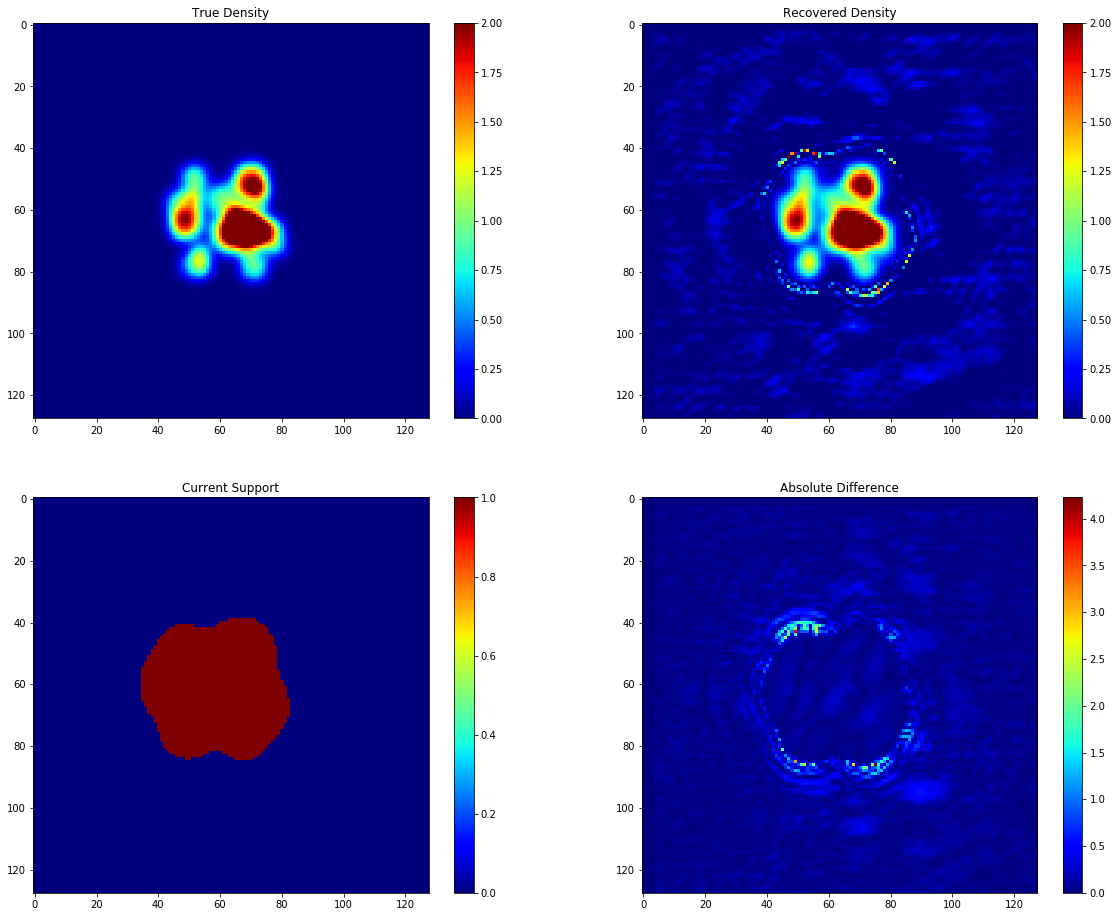

In [11]:
# Set up the canvas anc compare result
recover, _, _ = PhaseTool.util.resolve_trivial_ambiguity(array=np.fft.ifftshift(alter_proj.data_dict['density']), reference_array=sample.density)

print("The relative difference is {}%".format(np.sqrt(np.sum(np.square(recover - sample.density))) / np.sqrt(np.sum(np.square(sample.density)))))

fig, axes = plt.subplots(nrows=2, ncols=2)
fig.set_figheight(16)
fig.set_figwidth(20)

im = axes[0,0].imshow(sample.density, vmax=2, cmap='jet')
fig.colorbar(im, ax=axes[0,0])
axes[0,0].set_title("True Density")

im = axes[0,1].imshow(recover, vmin=0, vmax=2, cmap='jet')
fig.colorbar(im, ax=axes[0,1])
axes[0,1].set_title("Recovered Density")

im = axes[1,0].imshow(np.fft.ifftshift(alter_proj.data_dict['support']) , vmin= 0, vmax=1 , cmap='jet')
fig.colorbar(im, ax=axes[1,0])
axes[1,0].set_title("Current Support")

im = axes[1,1].imshow(np.abs(sample.density - recover),cmap='jet')
fig.colorbar(im, ax=axes[1,1])
axes[1,1].set_title("Absolute Difference")

# Show the canvas
plt.show()  

# Step 4 Try some ER

In [12]:
# Copy from history
alter_proj = copy.deepcopy(alter_proj_hist[-1])

alter_proj.set_algorithm(alg_name="ER")

alter_proj.set_beta_and_iter_num(iter_num=1000)

Since the argument beta is not specified, the arguments decay and decay_rate are ignored.


In [13]:
alter_proj.execute_algorithm()

# Save to history
alter_proj_hist.append(copy.deepcopy(alter_proj))

Using algorithm ER
Finishes self-consistency check.


# Visualization Section

The relative difference is 0.07428057761504804%


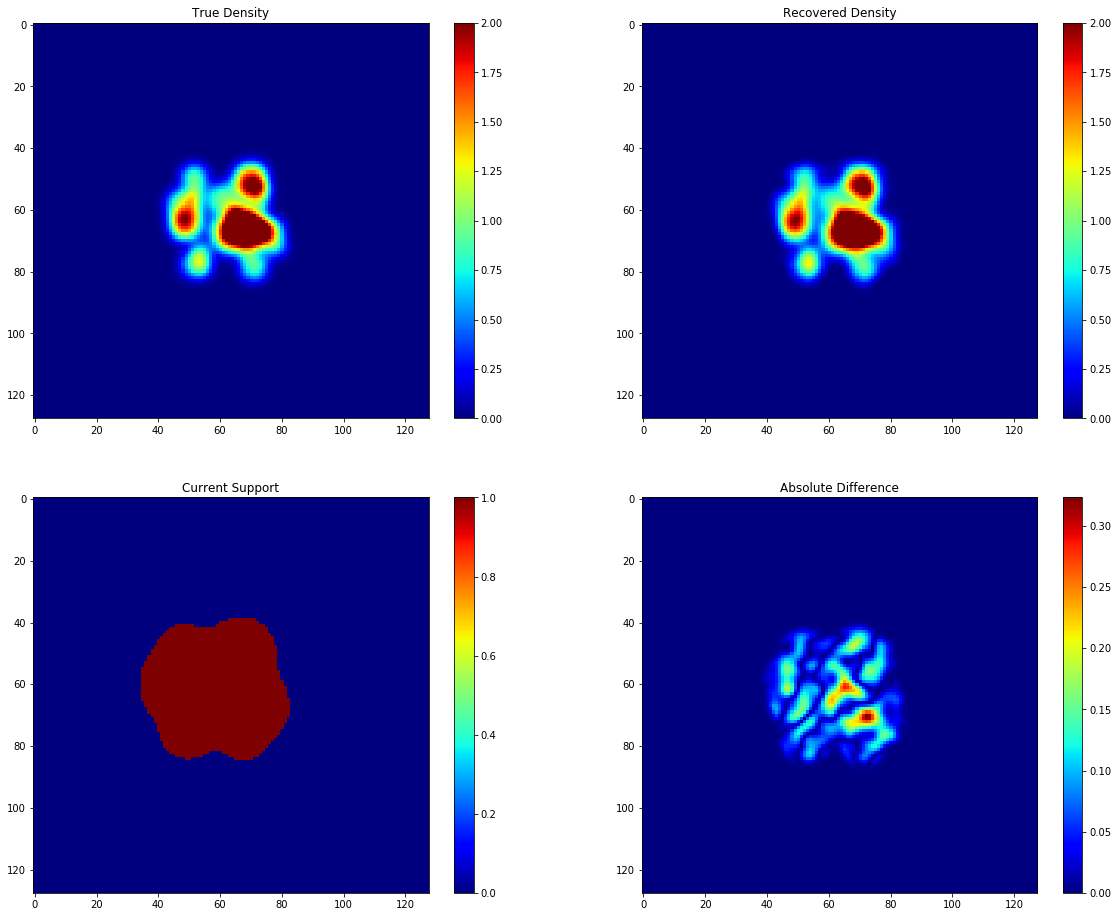

In [14]:
# Set up the canvas anc compare result
recover, _, _ = PhaseTool.util.resolve_trivial_ambiguity(array=np.fft.ifftshift(alter_proj.data_dict['density']), reference_array=sample.density)

print("The relative difference is {}%".format(np.sqrt(np.sum(np.square(recover - sample.density))) / np.sqrt(np.sum(np.square(sample.density)))))

fig, axes = plt.subplots(nrows=2, ncols=2)
fig.set_figheight(16)
fig.set_figwidth(20)

im = axes[0,0].imshow(sample.density, vmax=2, cmap='jet')
fig.colorbar(im, ax=axes[0,0])
axes[0,0].set_title("True Density")

im = axes[0,1].imshow(recover, vmin=0, vmax=2, cmap='jet')
fig.colorbar(im, ax=axes[0,1])
axes[0,1].set_title("Recovered Density")

im = axes[1,0].imshow(np.fft.ifftshift(alter_proj.data_dict['support']) , vmin= 0, vmax=1 , cmap='jet')
fig.colorbar(im, ax=axes[1,0])
axes[1,0].set_title("Current Support")

im = axes[1,1].imshow(np.abs(sample.density - recover),cmap='jet')
fig.colorbar(im, ax=axes[1,1])
axes[1,1].set_title("Absolute Difference")

# Show the canvas
plt.show()  